# 逻辑回归的模型实现

In [5]:
import torch
import torch.nn.functional as F #导入神经网络函数库
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# 数据准备
n_item = 1000   # 样本容量
n_feature = 2   # 特征维度
learning_rate = 0.001   #学习率
epochs = 100    # 训练轮数

# fake data：构造假数据
torch.manual_seed(123) #指定随机种子
data_x = torch.randn(size = (n_item,n_feature)).float() # 示例数据
# 这里标签的构造规则是：如果第一个数的0.5倍大于第二个数的0.5倍，则该样本标签取值为1，否则为0
data_y = torch.where(torch.subtract(data_x[:,0]*0.5,data_x[:,1]*1.5)>0,1.,0.).float() # 二分类标签



In [7]:
class LogisticRegressionMaually(object):
    
    def __init__(self):
        # 构造待估参数向量w
        self.w = torch.randn(size=(n_feature,1),requires_grad=True)
        # 构造偏置b
        self.b = torch.zeros(size=(1,1),requires_grad=True)
        # requires_grad=True 表示当前这个量是可以求导的，这里表示可以进行梯度更新

    # 定义前向转播计算,计算标签结果
    def forward(self,x):
        """
        支持两种输入形状：
        - 单个样本: [n_feature] 或 [1, n_feature]
        - 批量样本: [batch_size, n_feature]
        """
        if x.dim() == 1:
            x = x.unsqueeze(0)  # [n_feature] -> [1, n_feature]
        
        # 矩阵乘法: [batch,1,n_feature] @ [n_feature,1] -> [batch,1,1] -> [batch,1]
        y_hat = F.sigmoid(torch.matmul(x.unsqueeze(1), self.w).squeeze(2) + self.b)

        # # ​如果其中一个张量是一维的（x 是 [2]）​​：matmul 会自动在一维张量的前面插入一个维度，变成 [1, 2]（行向量）
        # y_hat = F.sigmoid(torch.matmul(self.w.transpose(0,1),x) + self.b)
        return y_hat    # 返回预测结果

    
    # 定义损失函数
    @staticmethod
    def loss_func(y_hat,y):
        #采用的损失函数是二分类交叉熵损失函数
        #对于单个样本
        return -(y * torch.log(y_hat) + (1-y) * torch.log(1-y_hat))
    
    def train(self):
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0
            # 1.load data 加载每一条样本数据
            for step in range(n_item):
                # 2.forward calc 前向传播，得出标签预测结果
                y_hat = self.forward(data_x[step])
                y = data_y[step]    # 真实标签结果
                # 3.loss calc 损失函数计算,计算单个样本的损失
                loss = self.loss_func(y_hat,y) # loss返回的是一个torch.Tensor对象
                # 4.backward 反向传播，求梯度
                loss.backward() # torch.Tensor对象自带backward方法
                # 5. update model 更新模型参数
                # 此时一遍训练中的梯度grad已经计算完成，接下来结合初始化学习率lr开始更新目标权重 w 和 b
                # 对于权重参数的更新过程，必须处于一个非梯度更新的状态下 ！！！
                with torch.no_grad():
                    # 参数更新
                    self.w.data -= learning_rate * self.w.grad.data
                    self.b.data -= learning_rate * self.b.grad.data
                
                # 更新完成后梯度清零
                self.w.grad.data.zero_()
                self.b.grad.data.zero_()
                
                epoch_loss += loss.item()
            
            avg_loss = epoch_loss / n_item

            losses.append(avg_loss)

            # 打印结果
            print('Epoch: {}, Loss: {}'.format(epoch,loss.item()))

        self.plot_results(losses)

    def plot_results(self, losses):
        plt.figure(figsize=(12, 5))
        
        # 1. 绘制损失曲线
        plt.subplot(1, 2, 1)
        plt.plot(losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        # 2. 绘制决策边界和数据点
        plt.subplot(1, 2, 2)
        # 创建网格数据
        x_min, x_max = data_x[:, 0].min()-1, data_x[:, 0].max()+1
        y_min, y_max = data_x[:, 1].min()-1, data_x[:, 1].max()+1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))
        
        # 预测网格点的类别
        with torch.no_grad():
            Z = self.forward(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
            Z = Z.reshape(xx.shape)
        
        # 绘制决策边界
        plt.contourf(xx, yy, Z.detach().numpy(), alpha=0.3, levels=[0, 0.5, 1])
        # 绘制数据点
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y.squeeze(), edgecolors='k')
        plt.title('Decision Boundary')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        
        plt.tight_layout()
        plt.show()


Epoch: 0, Loss: 0.5620617270469666
Epoch: 1, Loss: 0.5477286577224731
Epoch: 2, Loss: 0.5355436205863953
Epoch: 3, Loss: 0.5250095725059509
Epoch: 4, Loss: 0.5157642960548401
Epoch: 5, Loss: 0.507541298866272
Epoch: 6, Loss: 0.5001413822174072
Epoch: 7, Loss: 0.49341338872909546
Epoch: 8, Loss: 0.48724156618118286
Epoch: 9, Loss: 0.48153579235076904
Epoch: 10, Loss: 0.4762253761291504
Epoch: 11, Loss: 0.4712536334991455
Epoch: 12, Loss: 0.4665753245353699
Epoch: 13, Loss: 0.4621536433696747
Epoch: 14, Loss: 0.4579582214355469
Epoch: 15, Loss: 0.4539639949798584
Epoch: 16, Loss: 0.4501491189002991
Epoch: 17, Loss: 0.4464966058731079
Epoch: 18, Loss: 0.4429909288883209
Epoch: 19, Loss: 0.439619243144989
Epoch: 20, Loss: 0.43637001514434814
Epoch: 21, Loss: 0.4332335889339447
Epoch: 22, Loss: 0.4302010238170624
Epoch: 23, Loss: 0.4272646903991699
Epoch: 24, Loss: 0.4244181215763092
Epoch: 25, Loss: 0.42165514826774597
Epoch: 26, Loss: 0.41897040605545044
Epoch: 27, Loss: 0.416359066963195

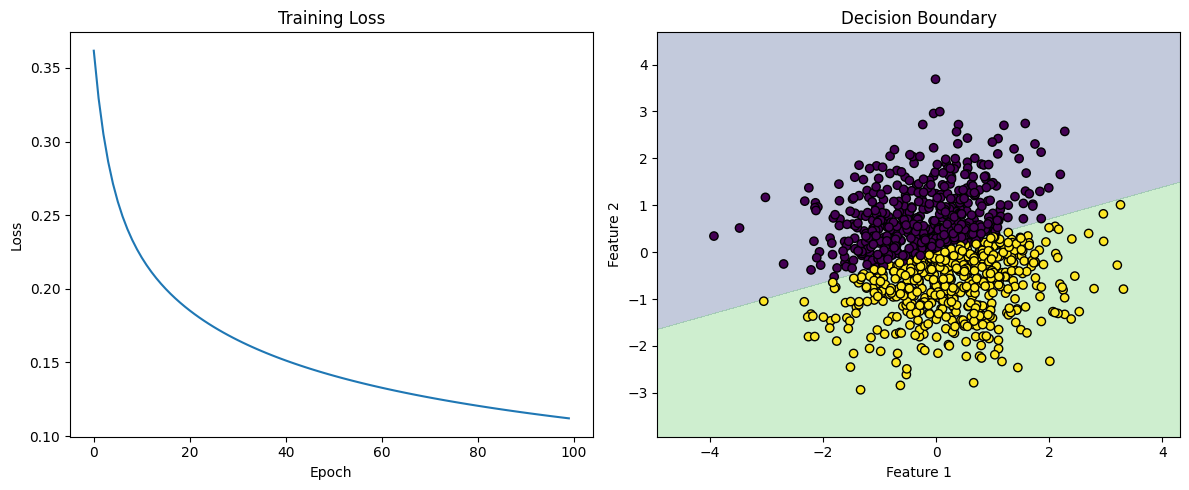

In [8]:
LogisticRegressionMaually().train()